<html>
<head>
<style>
    body {
        font-family: 'Arial', sans-serif;
        margin-left: 40px;
        background: #ECE9E6;  /* Color de fondo general */
        background: -webkit-linear-gradient(to right, #FFFFFF, #ECE9E6);  /* Degradado para Chrome */
        background: linear-gradient(to right, #FFFFFF, #ECE9E6);  /* Degradado estándar */
    }
    .header {
        color: #2E86C1; /* Azul oscuro */
        padding-bottom: 10px;
        font-size: 32px;
        font-weight: bold;
        border-bottom: 3px solid #2E86C1; /* Borde con el mismo color para consistencia */
    }
    .subheader {
        color: #3498DB; /* Azul un poco más claro */
        padding-top: 5px;
        font-size: 24px;
    }
    .description {
        color: #5DADE2; /* Azul aún más claro para el cuerpo de texto */
        padding: 20px 0;
        font-size: 16px;
        text-align: left;
    }
    .footer {
        color: #AED6F1; /* Azul muy claro para la fecha */
        font-size: 14px;
        padding-top: 30px;
    }
</style>
</head>
<body>

<div class="header">
    Predictor del total de ingresos hospitalarios por enfermedades respiratorias en zonas de la Ciudad de México
</div>

<div class="subheader">
    Predicción mediante modelos SARIMA
</div>


<div class="footer">
    Fecha: <strong>22 de abril de 2024</strong>
</div>

</body>
</html>


# Modelo ARIMA: Una Introducción

## ¿Qué es un modelo ARIMA?

ARIMA significa **AutoRegressive Integrated Moving Average**. Este es un tipo de modelo estadístico utilizado para analizar y predecir series de tiempo, es decir, datos que se recopilan y registran a lo largo del tiempo. Imagina que estás tratando de prever el clima; los modelos ARIMA podrían ayudarte a entender y prever cómo será el clima en los próximos días basándose en cómo ha sido en días anteriores.

## Componentes del Modelo ARIMA

Un modelo ARIMA tiene tres componentes principales:

### 1. **AR (AutoRegressive) - Autoregresivo**
   Este componente predice el valor futuro de una serie utilizando una combinación de valores pasados. Es como decir: "Si ayer hizo mucho calor y anteayer también, probablemente hoy también hará calor".

### 2. **I (Integrated) - Integrado**
   Este componente se ocupa de las diferencias entre los datos para hacer la serie de tiempo estacionaria. Una serie es estacionaria cuando sus propiedades estadísticas, como la media y la varianza, no cambian con el tiempo. Esto es necesario porque los modelos ARIMA necesitan que los datos sean estacionarios para hacer predicciones efectivas. Es similar a quitar la tendencia creciente de los datos para ver más claramente los patrones subyacentes.

### 3. **MA (Moving Average) - Media Móvil**
   Este componente utiliza el promedio de términos de error pasados para hacer predicciones. Puede considerarse como una forma de suavizar las fluctuaciones aleatorias en los datos, ayudando a ver la tendencia real más claramente.

## ¿Cómo funciona el modelo ARIMA?

Para utilizar un modelo ARIMA, primero debemos identificar los parámetros p, d, q que son:
- **p:** el número de términos autoregresivos.
- **d:** el número de diferencias necesarias para hacer la serie estacionaria.
- **q:** el número de términos de media móvil.

Una vez que tenemos estos parámetros, el modelo puede ser ajustado a los datos históricos. Esto implica estimar los pesos que se aplican a los términos en los componentes AR y MA, basándose en la minimización de errores entre las predicciones y los valores reales.

Después de ajustar el modelo, podemos usarlo para hacer predicciones sobre futuros valores de la serie de tiempo. Estas predicciones pueden ayudarnos a tomar decisiones informadas basadas en tendencias pasadas y patrones identificados.

-------------------------------------------------------------------------------------------------------
### Cluster 0

In [52]:
import pandas as pd
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.special import inv_boxcox
import plotly.graph_objects as go
from matplotlib import pyplot as plt

def cargar_datos_cluster(ruta_csv: str, cluster_id: int) -> pd.DataFrame:
    """
    Carga y transforma los datos de un CSV específico para un cluster determinado.
    
    Parameters:
    - ruta_csv: Ruta al archivo CSV.
    - cluster_id: ID del cluster cuyos datos se desean cargar.
    
    Returns:
    - DataFrame con los datos del cluster especificado, indexados por fecha.
    """
    df = pd.read_csv(ruta_csv)
    df.set_index('Cluster', inplace=True)
    df = df.transpose()
    cluster_data = df[cluster_id].reset_index()
    cluster_data.columns = ['Fecha', 'Contagios']
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    cluster_data.set_index('Fecha', inplace=True)
    return cluster_data


def preparar_datos(df: pd.DataFrame, n_preds: int = 10) -> tuple:
    """
    Prepara los datos para el modelado, aplicando transformación Box-Cox y dividiendo en entrenamiento y prueba.
    
    Parameters:
    - df: DataFrame que contiene los datos a modelar.
    - n_preds: Número de puntos de datos que se reservarán para pruebas.
    
    Returns:
    - Tupla con los datos de entrenamiento transformados, los datos de prueba y el valor lambda de Box-Cox.
    """
    df['Contagios'] = df['Contagios'].clip(lower=1)
    df['Contagios_transformed'], lambda_ = boxcox(df['Contagios'])
    train_data = df['Contagios_transformed'].iloc[:-n_preds]
    test_data = df.iloc[-n_preds:]
    return train_data, test_data, lambda_


def ajustar_modelo_sarima(train_data: pd.Series, order: tuple, seasonal_order: tuple) -> any:
    """
    Ajusta un modelo SARIMA a los datos proporcionados.
    
    Parameters:
    - train_data: Serie de datos de entrenamiento transformados.
    - order: Tupla especificando el orden del modelo ARIMA (p, d, q).
    - seasonal_order: Tupla especificando el orden estacional del modelo (P, D, Q, s).
    
    Returns:
    - Resultados del modelo ajustado.
    """
    model = SARIMAX(train_data,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit()
    
    print(results.summary())
    results.plot_diagnostics(figsize=(18, 8))
    plt.show()
    
    return results


def realizar_predicciones(results: any, steps: int, test_data: pd.DataFrame, lambda_: float) -> tuple:
    """
    Realiza predicciones futuras basadas en el modelo ajustado.
    
    Parameters:
    - results: Resultados del modelo SARIMA ajustado.
    - steps: Número de pasos de tiempo a predecir.
    - test_data: Datos de prueba.
    - lambda_: Valor lambda de la transformación Box-Cox.
    
    Returns:
    - Medias predichas y el intervalo de confianza de las predicciones.
    """
    datos_predicciones = results.get_forecast(steps=steps)
    prediccion_t = datos_predicciones.predicted_mean
    prediccion = inv_boxcox(prediccion_t, lambda_)
    pred_ci_transformed = datos_predicciones.conf_int()
    pred_intervalo_conf = pd.DataFrame()
    pred_intervalo_conf['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
    pred_intervalo_conf['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)
    prediccion.index = test_data.index
    return prediccion, pred_intervalo_conf


def visualizar_resultados(df: pd.DataFrame, pred_mean: pd.Series, pred_ci: pd.DataFrame, test_data: pd.DataFrame, cluster_id: int) -> None:
    """
    Visualiza los resultados de entrenamiento, prueba y predicción.
    
    Parameters:
    - df: DataFrame original con los datos.
    - pred_mean: Series con las medias predichas.
    - pred_ci: DataFrame con los intervalos de confianza de las predicciones.
    - test_data: DataFrame con los datos de prueba.
    - cluster_id: ID del cluster visualizado.
    """
    error_absoluto = abs(test_data['Contagios'] - pred_mean)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index[:-10], y=df['Contagios'][:-10], mode='lines+markers', name='Train'))
    fig.add_trace(go.Scatter(x=pred_mean.index, y=pred_mean, mode='lines+markers', name='Predicción'))
    fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
    fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))
    fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Test', line=dict(dash='dash')))
    fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))
    fig.update_layout(title=f'Gráfica de predicción - Cluster {cluster_id}',
                    xaxis_title='Fecha',
                    yaxis_title='Contagios',
                    legend_title='Leyenda')

    fig.show()

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90129D+00    |proj g|=  2.78427D-01

At iterate    5    f=  1.79950D+00    |proj g|=  1.12331D-01

At iterate   10    f=  1.78428D+00    |proj g|=  1.05218D-01

At iterate   15    f=  1.77935D+00    |proj g|=  5.25768D-03

At iterate   20    f=  1.77933D+00    |proj g|=  3.40891D-04

At iterate   25    f=  1.77932D+00    |proj g|=  2.48440D-03

At iterate   30    f=  1.77914D+00    |proj g|=  1.49895D-02

At iterate   35    f=  1.77814D+00    |proj g|=  1.61933D-02

At iterate   40    f=  1.77804D+00    |proj g|=  7.11321D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

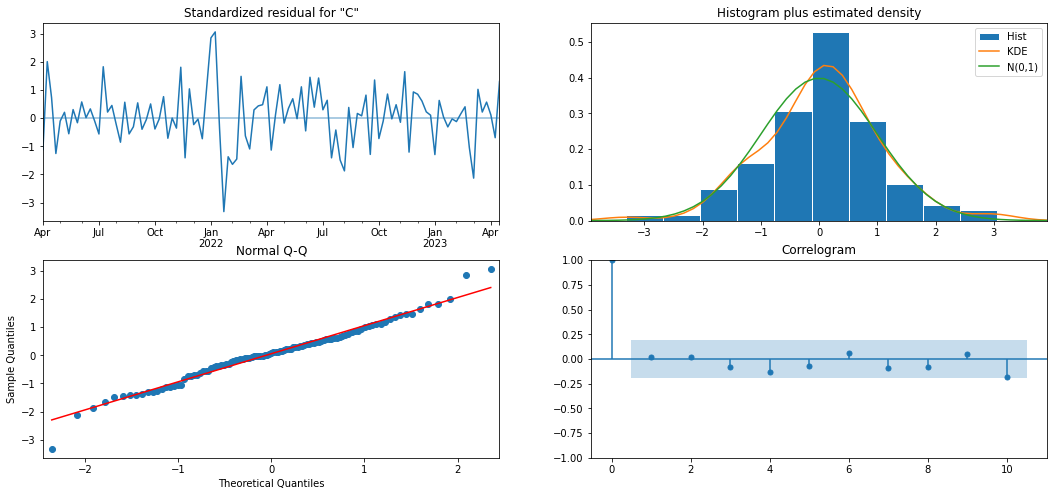

In [53]:
ruta_csv = 'clusterSemanal.csv'
cluster_id = 0
n_preds = 10

# (p,d,q), (P,D,Q,S)
params_ARIMA = (2, 2, 2)
params_estacional = (1, 1, 1, 30)

df = cargar_datos_cluster(ruta_csv, cluster_id)
train_data, test_data, lambda_ = preparar_datos(df, n_preds)

results = ajustar_modelo_sarima(train_data, params_ARIMA, params_estacional)
prediccion, pred_intervalo_conf = realizar_predicciones(results, n_preds, test_data, lambda_)
visualizar_resultados(df, prediccion, pred_intervalo_conf, test_data, cluster_id)



/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96072D+00    |proj g|=  2.77096D-01

At iterate    5    f=  1.83490D+00    |proj g|=  4.42849D-02

At iterate   10    f=  1.81221D+00    |proj g|=  3.46492D-02

At iterate   15    f=  1.81037D+00    |proj g|=  1.31587D-03

At iterate   20    f=  1.81010D+00    |proj g|=  5.45863D-03

At iterate   25    f=  1.80890D+00    |proj g|=  8.44336D-03

At iterate   30    f=  1.80885D+00    |proj g|=  6.52132D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

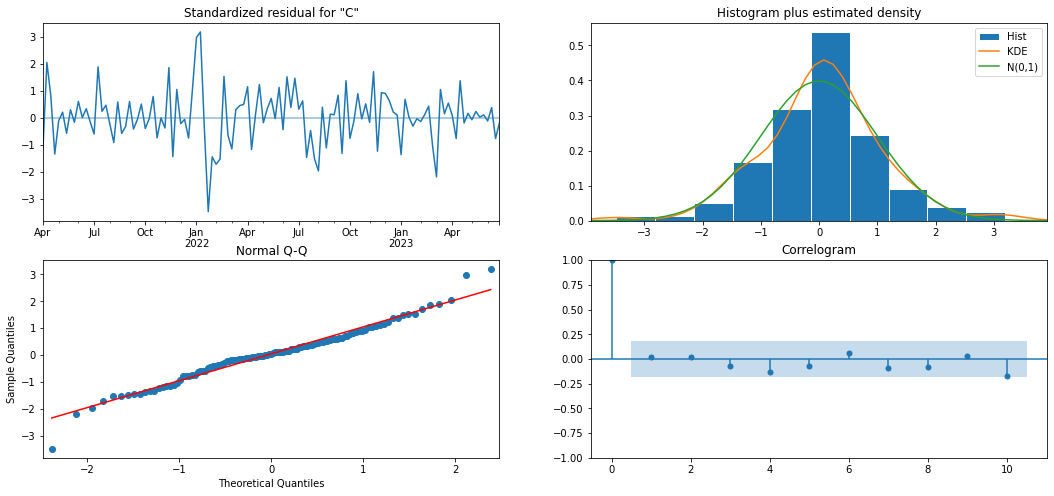

In [54]:
def preparar_datos_actuales(df):
    df['Contagios'] = df['Contagios'].clip(lower=1)
    df['Contagios_transformed'], lambda_ = boxcox(df['Contagios'])
    return df['Contagios_transformed'], lambda_


def realizar_predicciones_futuras(modelo, steps, lambda_):
    datos_predicciones = modelo.get_forecast(steps=steps)
    predicciones_t = datos_predicciones.predicted_mean
    predicciones = inv_boxcox(predicciones_t, lambda_)
    pred_ci_transformed = datos_predicciones.conf_int()
    pred_int_conf = pd.DataFrame()
    pred_int_conf['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
    pred_int_conf['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)
    ultima_fecha = modelo.data.dates[-1]
    fechas_predichas = pd.date_range(start=ultima_fecha + pd.DateOffset(days=1), periods=steps, freq='W')
    predicciones.index = fechas_predichas
    pred_int_conf.index = fechas_predichas
    return predicciones, pred_int_conf



def visualizar_predicciones_futuras(df, pred_mean, pred_ci, cluster_id):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df['Contagios'], mode='lines+markers', name='Observado'))

    fig.add_trace(go.Scatter(x=pred_mean.index, y=pred_mean, mode='lines+markers', name='Pronóstico'))

    fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci['lower'], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))

    fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci['upper'], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

    fig.update_layout(title=f'Predicción de Contagios - Cluster {cluster_id}',
                    xaxis_title='Fecha',
                    yaxis_title='Contagios',
                    legend_title='Leyenda')

    fig.show()


datos = cargar_datos_cluster(ruta_csv, cluster_id)
datos_transformados, lambda_ = preparar_datos_actuales(datos)
modelo_ajustado = ajustar_modelo_sarima(datos_transformados, params_ARIMA, params_estacional)
predicciones, intervalos_confianza = realizar_predicciones_futuras(modelo_ajustado, n_preds, lambda_)
visualizar_predicciones_futuras(datos, predicciones, intervalos_confianza, cluster_id)


-------------------------------------------------------------------------------------------------------
### Cluster 1

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85563D+00    |proj g|=  1.19771D-01

At iterate    5    f=  1.83151D+00    |proj g|=  3.03036D-02

At iterate   10    f=  1.80838D+00    |proj g|=  9.30991D-03

At iterate   15    f=  1.80759D+00    |proj g|=  1.67006D-02

At iterate   20    f=  1.80491D+00    |proj g|=  1.79880D-02

At iterate   25    f=  1.79768D+00    |proj g|=  9.49248D-01

At iterate   30    f=  1.78688D+00    |proj g|=  5.40064D-02

At iterate   35    f=  1.78665D+00    |proj g|=  2.28567D-02

At iterate   40    f=  1.78647D+00    |proj g|=  4.76494D-02

At iterate   45    f=  1.78641D+00    |proj g|=  1.04290D-02


/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.78636D+00    |proj g|=  1.00371D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   1.004D-03   1.786D+00
  F =   1.7863581552747798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:                  172
Model:             SARIMAX(1, 2, 5)x(1, 1, [1], 30)   Log Likelihood                -307.254
Date:                              Fri, 19 Apr 2024   AIC                         

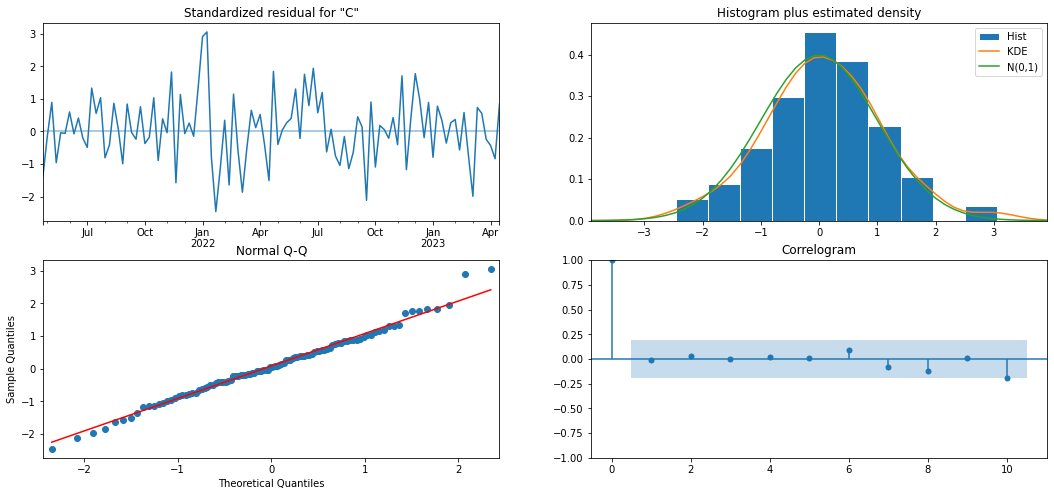

In [55]:
ruta_csv = 'clusterSemanal.csv'
cluster_id = 1
n_preds = 10

# (p,d,q), (P,D,Q,S)
params_ARIMA = (1, 2, 5)
params_estacional = (1, 1, 1, 30)
df = cargar_datos_cluster(ruta_csv, cluster_id)
train_data, test_data, lambda_ = preparar_datos(df, n_preds)
results = ajustar_modelo_sarima(train_data, params_ARIMA, params_estacional)
prediccion, pred_intervalo_conf = realizar_predicciones(results, n_preds, test_data, lambda_)
visualizar_resultados(df, prediccion, pred_intervalo_conf, test_data, cluster_id)


/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90508D+00    |proj g|=  1.21496D-01

At iterate    5    f=  1.88105D+00    |proj g|=  3.65996D-02

At iterate   10    f=  1.85282D+00    |proj g|=  2.62381D-02

At iterate   15    f=  1.85099D+00    |proj g|=  4.31114D-03

At iterate   20    f=  1.84985D+00    |proj g|=  1.25205D-02
  ys=-5.149E-03  -gs= 6.529E-04 BFGS update SKIPPED

At iterate   25    f=  1.84148D+00    |proj g|=  1.23118D+00

At iterate   30    f=  1.83083D+00    |proj g|=  4.40405D-02

At iterate   35    f=  1.83046D+00    |proj g|=  3.00122D-02

At iterate   40    f=  1.83034D+00    |proj g|=  3.03472D-02

At iterate   45    f=  1.83032D+00    |proj g|=  7.95428D-03


/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.83015D+00    |proj g|=  6.88590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     71      1     1     0   6.886D-03   1.830D+00
  F =   1.8301479015336295     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:                  182
Model:             SARIMAX(1, 2, 5)x(1, 1, [1], 30)   Log Likelihood                -333.087
Date:                              Fri, 19 Apr 2024   AIC                         

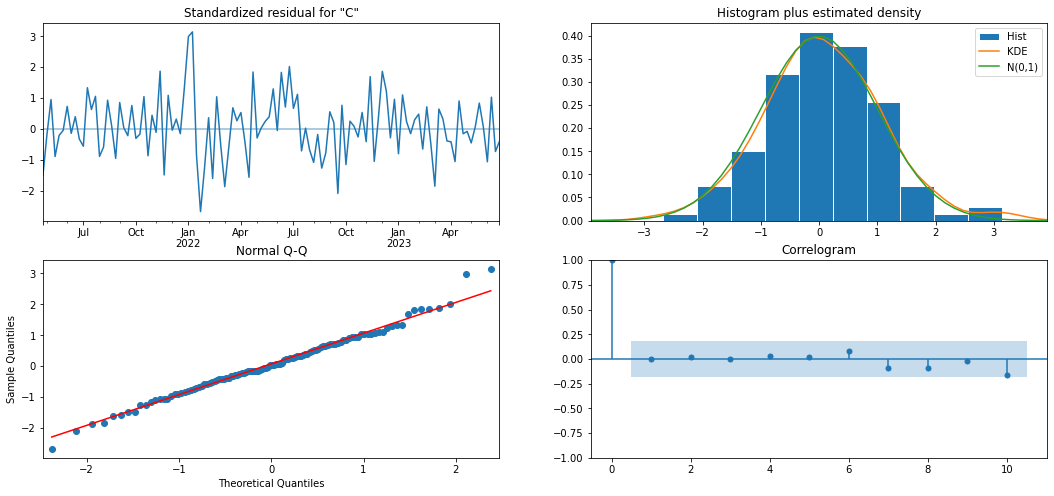

In [56]:
datos = cargar_datos_cluster(ruta_csv, cluster_id)
datos_transformados, lambda_ = preparar_datos_actuales(datos)
modelo_ajustado = ajustar_modelo_sarima(datos_transformados, params_ARIMA, params_estacional)
datos_predicciones, intervalos_confianza = realizar_predicciones_futuras(modelo_ajustado, n_preds, lambda_)
visualizar_predicciones_futuras(datos, datos_predicciones, intervalos_confianza, cluster_id)


-------------------------------------------------------------------------------------------------------
### Cluster 2

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81471D+00    |proj g|=  1.93627D-01

At iterate    5    f=  1.78690D+00    |proj g|=  2.33324D-02

At iterate   10    f=  1.77933D+00    |proj g|=  7.99734D-03

At iterate   15    f=  1.77892D+00    |proj g|=  3.67174D-04

At iterate   20    f=  1.77891D+00    |proj g|=  5.46017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     31      1     0     0   1.169D-06   1.779D+00
  F =   1.7789115281816277     

CONVERG

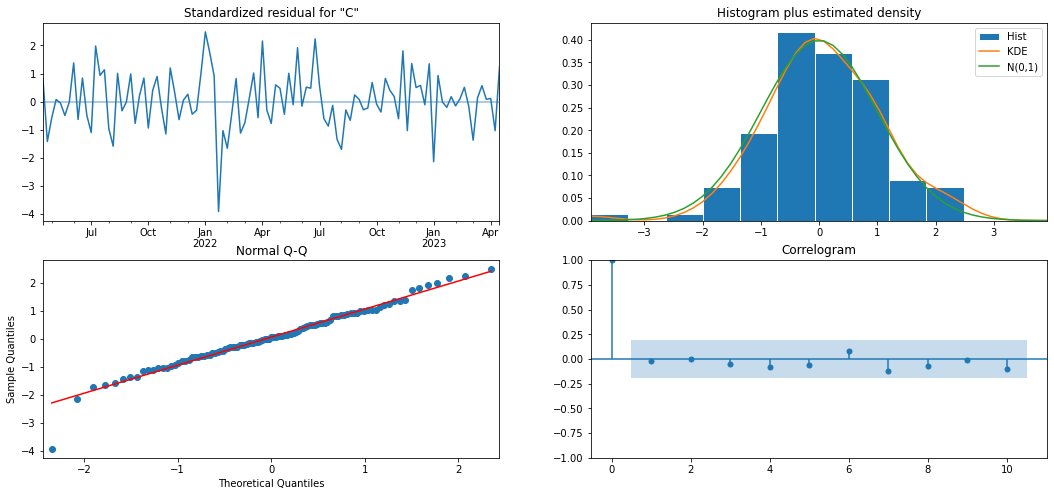

In [57]:
ruta_csv = 'clusterSemanal.csv'
cluster_id = 2
n_preds = 10

# (p,d,q), (P,D,Q,S)
params_ARIMA = (1, 2, 4)
params_estacional = (1, 1, 1, 30)
df = cargar_datos_cluster(ruta_csv, cluster_id)
train_data, test_data, lambda_ = preparar_datos(df, n_preds)
results = ajustar_modelo_sarima(train_data, params_ARIMA, params_estacional)
prediccion, pred_intervalo_conf = realizar_predicciones(results, n_preds, test_data, lambda_)
visualizar_resultados(df, prediccion, pred_intervalo_conf, test_data, cluster_id)

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85217D+00    |proj g|=  1.78756D-01

At iterate    5    f=  1.82776D+00    |proj g|=  2.74664D-02

At iterate   10    f=  1.81416D+00    |proj g|=  2.71161D-02

At iterate   15    f=  1.81340D+00    |proj g|=  2.04516D-03

At iterate   20    f=  1.81339D+00    |proj g|=  7.28876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   5.171D-06   1.813D+00
  F =   1.8133930651292671     

CONVERG

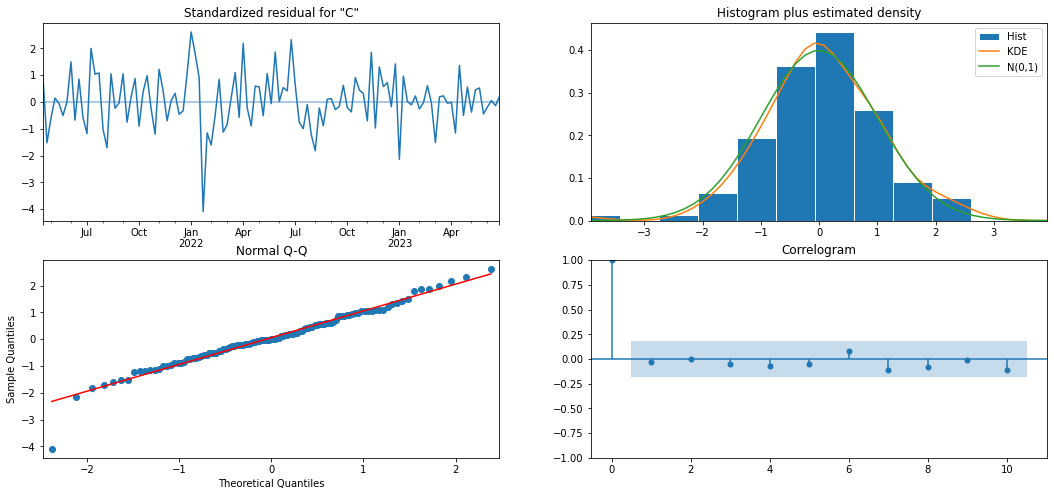

In [58]:
datos = cargar_datos_cluster(ruta_csv, cluster_id)
datos_transformados, lambda_ = preparar_datos_actuales(datos)
modelo_ajustado = ajustar_modelo_sarima(datos_transformados, params_ARIMA, params_estacional)
datos_predicciones, intervalos_confianza = realizar_predicciones_futuras(modelo_ajustado, n_preds, lambda_)
visualizar_predicciones_futuras(datos, datos_predicciones, intervalos_confianza, cluster_id)


-------------------------------------------------------------------------------------------------------
### Cluster 3

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63304D+00    |proj g|=  1.36135D-01

At iterate    5    f=  1.51924D+00    |proj g|=  7.86653D-02

At iterate   10    f=  1.49443D+00    |proj g|=  3.74589D-01

At iterate   15    f=  1.48550D+00    |proj g|=  8.36671D-02

At iterate   20    f=  1.47293D+00    |proj g|=  3.41067D-02

At iterate   25    f=  1.47147D+00    |proj g|=  1.81416D-01

At iterate   30    f=  1.47082D+00    |proj g|=  4.11895D-02

At iterate   35    f=  1.47031D+00    |proj g|=  9.67635D-02

At iterate   40    f=  1.46994D+00    |proj g|=  7.78642D-03

At iterate   45    f=  1.46962D+00    |proj g|=  9.06350D-02


/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.46929D+00    |proj g|=  5.57234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   5.572D-02   1.469D+00
  F =   1.4692915943162024     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:                  172
Model:             SARIMAX(1, 3, 5)x(1, 1, [1], 30)   Log Likelihood                -252.718
Date:                              Fri, 19 Apr 2024   AIC                         

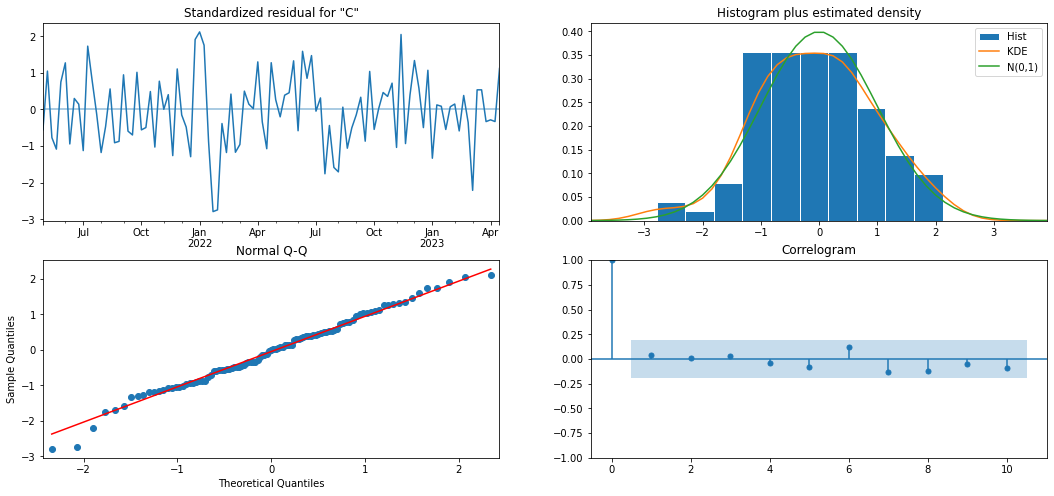

In [59]:
ruta_csv = 'clusterSemanal.csv'
cluster_id = 3
n_preds = 10

# (p,d,q), (P,D,Q,S)
params_ARIMA = (1, 3, 5)
params_estacional = (1, 1, 1, 30)
df = cargar_datos_cluster(ruta_csv, cluster_id)
train_data, test_data, lambda_ = preparar_datos(df, n_preds)
results = ajustar_modelo_sarima(train_data, params_ARIMA, params_estacional)
prediccion, pred_intervalo_conf = realizar_predicciones(results, n_preds, test_data, lambda_)
visualizar_resultados(df, prediccion, pred_intervalo_conf, test_data, cluster_id)

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65785D+00    |proj g|=  1.60075D-01

At iterate    5    f=  1.54826D+00    |proj g|=  1.58353D-01

At iterate   10    f=  1.52549D+00    |proj g|=  6.09208D-02

At iterate   15    f=  1.50946D+00    |proj g|=  5.65706D-02

At iterate   20    f=  1.50339D+00    |proj g|=  4.10860D-01

At iterate   25    f=  1.49993D+00    |proj g|=  1.80660D-02

At iterate   30    f=  1.49961D+00    |proj g|=  1.41210D-01

At iterate   35    f=  1.49878D+00    |proj g|=  1.99441D-01

At iterate   40    f=  1.49764D+00    |proj g|=  3.55270D-02

At iterate   45    f=  1.49756D+00    |proj g|=  3.00665D-02


/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.49678D+00    |proj g|=  8.78812D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   8.788D-02   1.497D+00
  F =   1.4967831041795843     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:                  182
Model:             SARIMAX(1, 3, 5)x(1, 1, [1], 30)   Log Likelihood                -272.415
Date:                              Fri, 19 Apr 2024   AIC                         

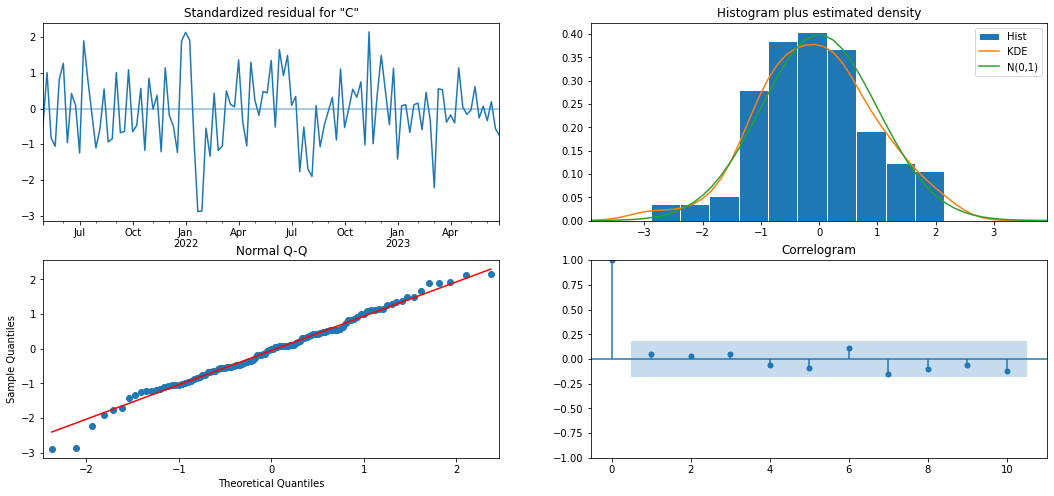

In [60]:
datos = cargar_datos_cluster(ruta_csv, cluster_id)
datos_transformados, lambda_ = preparar_datos_actuales(datos)
modelo_ajustado = ajustar_modelo_sarima(datos_transformados, params_ARIMA, params_estacional)
datos_predicciones, intervalos_confianza = realizar_predicciones_futuras(modelo_ajustado, n_preds, lambda_)
visualizar_predicciones_futuras(datos, datos_predicciones, intervalos_confianza, cluster_id)

-------------------------------------------------------------------------------------------------------
### Cluster 4

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47175D+00    |proj g|=  1.74308D-01

At iterate    5    f=  1.44675D+00    |proj g|=  3.11964D-02

At iterate   10    f=  1.44235D+00    |proj g|=  1.69431D-03

At iterate   15    f=  1.44231D+00    |proj g|=  2.17617D-03

At iterate   20    f=  1.44230D+00    |proj g|=  5.60213D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     25      1     0     0   2.371D-05   1.442D+00
  F =   1.4423007490882698     

CONVERG

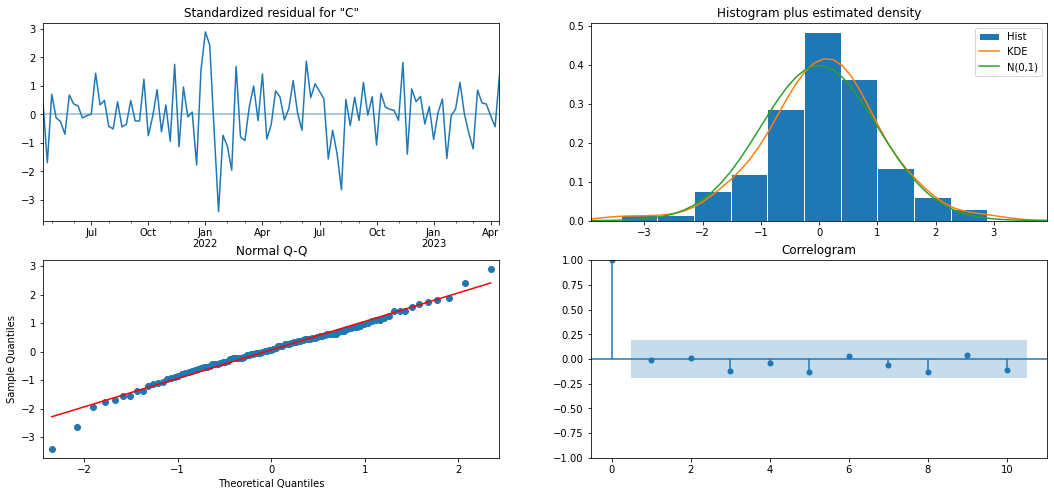

In [61]:
ruta_csv = 'clusterSemanal.csv'
cluster_id = 4
n_preds = 10

# (p,d,q), (P,D,Q,S)
params_ARIMA = (1, 2, 4)
params_estacional = (1, 1, 1, 30)
df = cargar_datos_cluster(ruta_csv, cluster_id)
train_data, test_data, lambda_ = preparar_datos(df, n_preds)
results = ajustar_modelo_sarima(train_data, params_ARIMA, params_estacional)
prediccion, pred_intervalo_conf = realizar_predicciones(results, n_preds, test_data, lambda_)
visualizar_resultados(df, prediccion, pred_intervalo_conf, test_data, cluster_id)

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49639D+00    |proj g|=  1.67253D-01

At iterate    5    f=  1.47331D+00    |proj g|=  2.89384D-02

At iterate   10    f=  1.46916D+00    |proj g|=  2.79516D-03

At iterate   15    f=  1.46913D+00    |proj g|=  1.37524D-03

At iterate   20    f=  1.46911D+00    |proj g|=  1.09692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   9.752D-06   1.469D+00
  F =   1.4691078248006124     

CONVERG

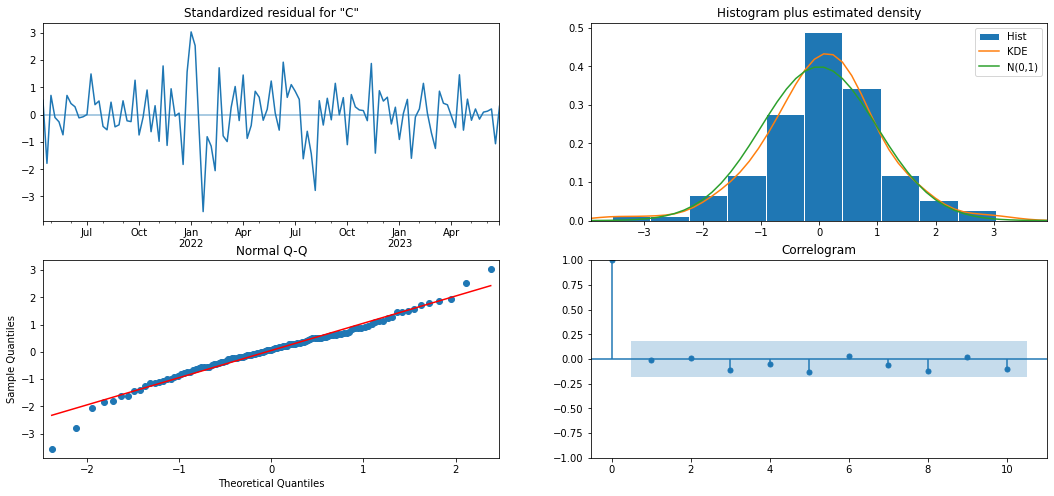

In [62]:
datos = cargar_datos_cluster(ruta_csv, cluster_id)
datos_transformados, lambda_ = preparar_datos_actuales(datos)
modelo_ajustado = ajustar_modelo_sarima(datos_transformados, params_ARIMA, params_estacional)
datos_predicciones, intervalos_confianza = realizar_predicciones_futuras(modelo_ajustado, n_preds, lambda_)
visualizar_predicciones_futuras(datos, datos_predicciones, intervalos_confianza, cluster_id)